This code is an implementation of a **time series forecasting model using XGBoost**, a popular gradient boosting algorithm. The model is trained on a dataset of unit sales data for a number of unique items and stores, and the goal is to predict future unit sales for each unique item-store combination.

The code begins by reading in the dataset and performing some preprocessing steps, including adding a unique ID column, dropping irrelevant columns, and one-hot encoding the category column. It then splits the data into training and test sets for each unique item-store combination and performs cross-validation on the training data using a TimeSeriesSplit.

The XGBoost model is then trained on the training data for each unique item-store combination, and the model is used to make predictions for the next day's unit sales using a sliding window approach. The predictions are stored in a dataframe along with the actual values, and the results are plotted for each unique item-store combination.

Overall, the code implements a robust and flexible time series forecasting model that can be easily adapted to other datasets and forecasting problems.

In [1]:
import numpy as np
import pandas as pd
import random
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import xgboost as xgb

# Define the path to 'total.csv'
#total_csv_path = '/kaggle/input/total-final/total.csv'
total_csv_path = '/kaggle/input/total-with-category/total_with_category.csv'

# Load 'total.csv' and set index to 'date'
#data = pd.read_csv(total_csv_path, parse_dates=['date'], index_col='date')
data = pd.read_csv(total_csv_path)
data = data[data['store'] == 548]

# Add 'unique_id' column
data['unique_id'] = data['item_nbr'].astype(str) + '_' + data['store'].astype(str)

# Drop 'item_nbr' and 'store' columns
data.drop(['item_nbr', 'store'], axis=1, inplace=True)

# Select 1 random unique_ids and filter the data
random_unique_ids = random.sample(list(data['unique_id'].unique()), 30)
data = data[data['unique_id'].isin(random_unique_ids)]

#data = data.drop('index', axis=1)
# Sort the data by 'unique_id' and 'date'
data.sort_values(by=['unique_id', 'date'], inplace=True)

# Convert the date column to a datetime object and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
                        
# Assuming the data is already loaded into the DataFrame 'data'
data['category'] = data['category'].fillna('undefined')

# One-hot encoding for the 'category' column if there are more categories
data = pd.get_dummies(data, columns=['category'])

data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


unit_sales  bogo  circular_discount  circular  circedlp  coupon  \
date                                                                          
2021-01-23         2.0   0.0                0.0       0.0       0.0     0.0   
2021-01-24         5.0   0.0                0.0       0.0       0.0     0.0   
2021-01-25         0.0   0.0                0.0       0.0       0.0     0.0   
2021-01-26         3.0   0.0                0.0       0.0       0.0     0.0   
2021-01-27         0.0   0.0                0.0       0.0       0.0     0.0   
...                ...   ...                ...       ...       ...     ...   
2023-02-18         1.0   0.0                0.0       0.0       0.0     0.0   
2023-02-19         3.0   0.0                0.0       0.0       0.0     0.0   
2023-02-20         0.0   0.0                0.0       0.0       0.0     0.0   
2023-02-21         0.0   0.0                0.0       0.0       0.0     0.0   
2023-02-22         0.0   0.0                0.0       0.0       0.0     0.0   

            discount_value  discount  fp_discount  front_page  fpedlp  gas  \
date                                                                         
2021-01-23          0.2084       1.0          0.0         0.0     0.0  0.0   
2021-01-24          0.0000       0.0          0.0         0.0     0.0  0.0   
2021-01-25          0.0000       0.0          0.0         0.0     0.0  0.0   
2021-01-26          0.0000       0.0          0.0         0.0     0.0  0.0   
2021-01-27          0.0000       0.0          0.0         0.0     0.0  0.0   
...                    ...       ...          ...         ...     ...  ...   
2023-02-18          0.0000       0.0          0.0         0.0     0.0  0.0   
2023-02-19          0.0000       0.0          0.0         0.0     0.0  0.0   
2023-02-20          0.0000       0.0          0.0         0.0     0.0  0.0   
2023-02-21          0.0000       0.0          0.0         0.0     0.0  0.0   
2023-02-22          0.0000       0.0          0.0         0.0     0.0  0.0   

            nopromo  unique_id  category_DAIRY  category_FROZEN  \
date                                                              
2021-01-23      0.0  11005_548               0                0   
2021-01-24      1.0  11005_548               0                0   
2021-01-25      1.0  11005_548               0                0   
2021-01-26      1.0  11005_548               0                0   
2021-01-27      1.0  11005_548               0                0   
...             ...        ...             ...              ...   
2023-02-18      1.0  98011_548               0                0   
2023-02-19      1.0  98011_548               0                0   
2023-02-20      1.0  98011_548               0                0   
2023-02-21      1.0  98011_548               0                0   
2023-02-22      1.0  98011_548               0                0   

            category_GROCERY  category_HBC  category_MEAT  category_PRODUCE  
date                                                                         
2021-01-23                 1             0              0                 0  
2021-01-24                 1             0              0                 0  
2021-01-25                 1             0              0                 0  
2021-01-26                 1             0              0                 0  
2021-01-27                 1             0              0                 0  
...                      ...           ...            ...               ...  
2023-02-18                 1             0              0                 0  
2023-02-19                 1             0              0                 0  
2023-02-20                 1             0              0                 0  
2023-02-21                 1             0              0                 0  
2023-02-22                 1             0              0                 0  

[22830 rows x 20 columns]

**Cross-validation** is a technique used to evaluate the performance of a machine learning model by training and testing it on different subsets of the data. In this case, the TimeSeriesSplit class is used to split the time series data into multiple folds to evaluate the model's performance over time.

In [2]:
train_ratio = 0.8

# Create a dictionary to store train and test data for each unique_id
train_test_data = {}

for i, unique_id in enumerate(random_unique_ids):
    unique_id_data = data[data['unique_id'] == unique_id]
    train_size = int(len(unique_id_data) * train_ratio)
    train = unique_id_data.iloc[:train_size]
    test = unique_id_data.iloc[train_size:]

    # Perform cross-validation on the train set
    train = train.sort_index()

    tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)

    # Create a list to store train and test folds for each unique_id
    train_test_folds = []
    for train_idx, val_idx in tss.split(train):
        train_fold = train.iloc[train_idx]
        test_fold = train.iloc[val_idx]
        train_test_folds.append((train_fold, test_fold))

    # Store train and test data in the dictionary
    train_test_data[unique_id] = {'train': train, 'test': test, 'folds': train_test_folds}


# Train

In [3]:
# Concatenate train sets from all unique_ids
all_train_data = pd.concat([train_test_data[unique_id]['train'] for unique_id in random_unique_ids])

all_train_data = all_train_data.sort_index()

# Create a TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(all_train_data):
    train_fold = all_train_data.iloc[train_idx]
    val_fold = all_train_data.iloc[val_idx]

    FEATURES = ['bogo', 'circular_discount', 'circular', 'circedlp', 'coupon', 'discount_value', 'discount', 'fp_discount', 'front_page', 'fpedlp', 'gas', 'nopromo']
    TARGET = 'unit_sales'

    X_train = train_fold[FEATURES]
    y_train = train_fold[TARGET]

    X_val = val_fold[FEATURES]
    y_val = val_fold[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)


[0]	validation_0-rmse:11.54168	validation_1-rmse:5.03302
[100]	validation_0-rmse:10.12054	validation_1-rmse:4.04693
[200]	validation_0-rmse:9.73512	validation_1-rmse:3.92297
[300]	validation_0-rmse:9.55475	validation_1-rmse:3.82405
[350]	validation_0-rmse:9.49437	validation_1-rmse:3.84011
[0]	validation_0-rmse:11.51544	validation_1-rmse:8.96827
[100]	validation_0-rmse:10.09745	validation_1-rmse:8.54081
[200]	validation_0-rmse:9.71517	validation_1-rmse:8.48029
[300]	validation_0-rmse:9.53565	validation_1-rmse:8.46220
[400]	validation_0-rmse:9.43415	validation_1-rmse:8.45598
[500]	validation_0-rmse:9.33704	validation_1-rmse:8.45459
[600]	validation_0-rmse:9.26873	validation_1-rmse:8.45428
[658]	validation_0-rmse:9.23553	validation_1-rmse:8.45452
[0]	validation_0-rmse:11.50282	validation_1-rmse:7.79683
[100]	validation_0-rmse:10.09234	validation_1-rmse:7.48853
[200]	validation_0-rmse:9.70747	validation_1-rmse:7.47847
[300]	validation_0-rmse:9.52986	validation_1-rmse:7.47368
[400]	validati

In [4]:
print(f'Mean score across folds: {np.mean(scores):.4f}')
print(f'Fold scores: {scores}')

Mean score across folds: 6.9771
Fold scores: [3.8240511316807213, 8.454251022332869, 7.448345313734316, 10.833657728222908, 4.325128691009944]


In [5]:
FEATURES = ['bogo', 'circular_discount', 'circular', 'circedlp', 'coupon', 'discount_value', 'discount', 'fp_discount', 'front_page', 'fpedlp', 'gas', 'nopromo']
TARGET = 'unit_sales'

X_all = all_train_data[FEATURES]
y_all = all_train_data[TARGET]


reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,  # Increase the number of estimators
                       objective='reg:squarederror',
                       max_depth=5,  # Increase the maximum depth
                       learning_rate=0.01,
                       early_stopping_rounds=10)  # Add early stopping rounds

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)


[0]	validation_0-rmse:11.48295	validation_1-rmse:8.61710
[100]	validation_0-rmse:9.64876	validation_1-rmse:5.01496
[200]	validation_0-rmse:9.21471	validation_1-rmse:3.98854
[272]	validation_0-rmse:9.10383	validation_1-rmse:3.90722


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Test

In [8]:
'''from joblib import Parallel, delayed


# Prepare an empty DataFrame to store the predictions
predictions_df = pd.DataFrame(columns=['unique_id', 'date', 'actuals', 'predicted'])

# Set the window size and horizon
window_size = 14
horizon = 1

# Iterate through each unique_id in the test set
for unique_id in random_unique_ids:
    test_unique_id = train_test_data[unique_id]['test']

    # Iterate through the test set using the sliding window method
    for i in range(0, len(test_unique_id) - window_size - horizon + 1):
        # Select the window from the test set
        window = test_unique_id.iloc[i:i+window_size]

        # Prepare the features and target for the window
        X_window = window[FEATURES]
        y_window = window[TARGET]

        # Fit the model on the window
        reg.fit(X_window, y_window,
                eval_set=[(X_window, y_window)],
                verbose=100)

        # Make a prediction for the next day
        X_next_day = test_unique_id[FEATURES].iloc[i+window_size]
        y_next_day = test_unique_id[TARGET].iloc[i+window_size]
        y_pred = reg.predict(np.array(X_next_day).reshape(1, -1))

        predictions_df = pd.concat([predictions_df, pd.DataFrame([{
            'unique_id': test_unique_id['unique_id'].iloc[i+window_size],
            'date': test_unique_id.index[i+window_size],
            'actuals': y_next_day,
            'predicted': y_pred[0]
        }], columns=predictions_df.columns)], ignore_index=True)
        
'''

from tqdm import tqdm

def sliding_window_prediction(unique_id):
    test_unique_id = train_test_data[unique_id]['test']
    unique_id_predictions = []

    for i in range(0, len(test_unique_id) - window_size - horizon + 1):
        window = test_unique_id.iloc[i:i + window_size]
        X_window = window[FEATURES]
        y_window = window[TARGET]

        reg.fit(X_window, y_window,
                eval_set=[(X_window, y_window)],
                verbose=100)

        X_next_day = test_unique_id[FEATURES].iloc[i + window_size]
        y_next_day = test_unique_id[TARGET].iloc[i + window_size]
        y_pred = reg.predict(np.array(X_next_day).reshape(1, -1))

        unique_id_predictions.append({
            'unique_id': test_unique_id['unique_id'].iloc[i + window_size],
            'date': test_unique_id.index[i + window_size],
            'actuals': y_next_day,
            'predicted': y_pred[0]
        })

    return unique_id_predictions

#predictions_list = Parallel(n_jobs=-1)(delayed(sliding_window_prediction)(unique_id) for unique_id in random_unique_ids)
predictions_list = Parallel(n_jobs=-1)(delayed(sliding_window_prediction)(unique_id) for unique_id in tqdm(random_unique_ids, desc="Predicting"))

predictions_df = pd.DataFrame(columns=['unique_id', 'date', 'actuals', 'predicted'])

for unique_id_predictions in predictions_list:
    predictions_df = pd.concat([predictions_df, pd.DataFrame(unique_id_predictions, columns=predictions_df.columns)], ignore_index=True)


Predicting:   0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[0]	validation_0-rmse:1.58568
[100]	validation_0-rmse:1.24918
[200]	validation_0-rmse:1.18921
[300]	validation_0-rmse:1.17975
[400]	validation_0-rmse:1.17829
[499]	validation_0-rmse:1.17807
[0]	validation_0-rmse:1.11532
[0]	validation_0-rmse:1.67247
[100]	validation_0-rmse:0.98620
[100]	validation_0-rmse:1.30076
[200]	validation_0-rmse:0.96488
[200]	validation_0-rmse:1.20928
[300]	validation_0-rmse:0.96157
[300]	validation_0-rmse:1.18399
[400]	validation_0-rmse:0.96107
[400]	validation_0-rmse:1.17614
[499]	validation_0-rmse:0.96099
[0]	validation_0-rmse:1.11459
[499]	validation_0-rmse:1.17350
[100]	validation_0-rmse:0.94811
[0]	validation_0-rmse:1.75486
[200]	validation_0-rmse:0.91993
[100]	validation_0-rmse:1.31149
[300]	validation_0-rmse:0.91553
[200]	validation_0-rmse:1.19934
[400]	validation_0-rmse:0.91485
[300]	validation_0-rmse:1.17315
[499]	validation_0-rmse:0.91475
[400]	validation_0-rmse:1.16697
[0]	validation_0-rmse:1.11459
[499]	validation_0-rmse:1.16548
[100]	validation_0-r

Predicting:  13%|█▎        | 4/30 [00:33<03:36,  8.31s/it]

[499]	validation_0-rmse:0.45176[499]	validation_0-rmse:1.16285

[0]	validation_0-rmse:0.49915
[100]	validation_0-rmse:0.45934
[200]	validation_0-rmse:0.45292
[300]	validation_0-rmse:0.45193
[400]	validation_0-rmse:0.45178
[0]	validation_0-rmse:0.62648
[499]	validation_0-rmse:0.45176
[0]	validation_0-rmse:0.49848
[100]	validation_0-rmse:0.61280
[100]	validation_0-rmse:0.42503
[200]	validation_0-rmse:0.41261
[200]	validation_0-rmse:0.61067
[300]	validation_0-rmse:0.41068
[300]	validation_0-rmse:0.61035
[400]	validation_0-rmse:0.41038
[400]	validation_0-rmse:0.61030
[499]	validation_0-rmse:0.41033
[499]	validation_0-rmse:0.61029
[0]	validation_0-rmse:0.49915
[0]	validation_0-rmse:0.62646
[100]	validation_0-rmse:0.45934
[100]	validation_0-rmse:0.60910
[200]	validation_0-rmse:0.45292
[200]	validation_0-rmse:0.60441
[300]	validation_0-rmse:0.45193
[300]	validation_0-rmse:0.60296
[400]	validation_0-rmse:0.45178
[400]	validation_0-rmse:0.60247
[499]	validation_0-rmse:0.45176
[499]	validation_0

Predicting:  20%|██        | 6/30 [01:05<04:35, 11.50s/it]

[100]	validation_0-rmse:0.78032
[499]	validation_0-rmse:0.53472
[200]	validation_0-rmse:0.69033
[0]	validation_0-rmse:1.44115
[300]	validation_0-rmse:0.67360
[100]	validation_0-rmse:0.83469
[400]	validation_0-rmse:0.67067
[200]	validation_0-rmse:0.68724
[499]	validation_0-rmse:0.67017
[300]	validation_0-rmse:0.66009
[400]	validation_0-rmse:0.65555
[499]	validation_0-rmse:0.65480
[0]	validation_0-rmse:1.48894
[100]	validation_0-rmse:0.84583
[0]	validation_0-rmse:2.11411
[200]	validation_0-rmse:0.68905
[100]	validation_0-rmse:1.21076
[300]	validation_0-rmse:0.66035
[400]	validation_0-rmse:0.65559
[200]	validation_0-rmse:0.99357
[499]	validation_0-rmse:0.65481
[300]	validation_0-rmse:0.95431
[0]	validation_0-rmse:1.48894
[400]	validation_0-rmse:0.94766
[100]	validation_0-rmse:0.84583
[499]	validation_0-rmse:0.94645
[200]	validation_0-rmse:0.68905
[0]	validation_0-rmse:2.08066
[100]	validation_0-rmse:1.19366
[300]	validation_0-rmse:0.66035
[200]	validation_0-rmse:0.97728
[300]	validation_0

Predicting:  27%|██▋       | 8/30 [01:36<04:48, 13.12s/it]

[200]	validation_0-rmse:1.51376
[100]	validation_0-rmse:0.98985
[300]	validation_0-rmse:1.51215
[200]	validation_0-rmse:0.85582
[400]	validation_0-rmse:1.51190
[300]	validation_0-rmse:0.82958
[499]	validation_0-rmse:1.51186
[400]	validation_0-rmse:0.82480
[499]	validation_0-rmse:0.82394
[0]	validation_0-rmse:1.49000
[100]	validation_0-rmse:0.89839
[0]	validation_0-rmse:31.49232
[100]	validation_0-rmse:15.95401
[200]	validation_0-rmse:0.74487
[200]	validation_0-rmse:11.89624
[300]	validation_0-rmse:0.71400
[300]	validation_0-rmse:11.12438
[400]	validation_0-rmse:0.70834
[400]	validation_0-rmse:10.98625
[499]	validation_0-rmse:0.70733
[499]	validation_0-rmse:10.96234
[0]	validation_0-rmse:1.49034
[0]	validation_0-rmse:30.91335
[100]	validation_0-rmse:0.93423
[100]	validation_0-rmse:16.23729
[200]	validation_0-rmse:0.80018
[200]	validation_0-rmse:12.48119
[300]	validation_0-rmse:0.77472
[300]	validation_0-rmse:11.70931
[400]	validation_0-rmse:0.77025
[400]	validation_0-rmse:11.56857
[499]

Predicting:  33%|███▎      | 10/30 [02:08<04:40, 14.02s/it]

[200]	validation_0-rmse:0.55640
[499]	validation_0-rmse:9.30009
[300]	validation_0-rmse:0.54340
[400]	validation_0-rmse:0.54098
[499]	validation_0-rmse:0.54053
[0]	validation_0-rmse:0.98121
[0]	validation_0-rmse:0.90076
[100]	validation_0-rmse:0.94601
[100]	validation_0-rmse:0.57806
[200]	validation_0-rmse:0.94050
[200]	validation_0-rmse:0.49776
[300]	validation_0-rmse:0.93965
[300]	validation_0-rmse:0.48174
[400]	validation_0-rmse:0.93952
[400]	validation_0-rmse:0.47876
[499]	validation_0-rmse:0.93950
[499]	validation_0-rmse:0.47822
[0]	validation_0-rmse:0.73167
[0]	validation_0-rmse:0.90076
[100]	validation_0-rmse:0.71998
[100]	validation_0-rmse:0.57806
[200]	validation_0-rmse:0.71818
[200]	validation_0-rmse:0.49776
[300]	validation_0-rmse:0.71790
[300]	validation_0-rmse:0.48174
[400]	validation_0-rmse:0.71786
[400]	validation_0-rmse:0.47876
[499]	validation_0-rmse:0.71785
[499]	validation_0-rmse:0.47822
[0]	validation_0-rmse:0.62678
[10]	validation_0-rmse:0.62678
[0]	validation_0-rm

Predicting:  40%|████      | 12/30 [02:36<04:13, 14.08s/it]

[499]	validation_0-rmse:3.52925
[300]	validation_0-rmse:1.14598
[0]	validation_0-rmse:5.54567
[400]	validation_0-rmse:1.14102
[100]	validation_0-rmse:3.87021
[499]	validation_0-rmse:1.13992
[200]	validation_0-rmse:3.54404
[300]	validation_0-rmse:3.49135
[400]	validation_0-rmse:3.48321
[0]	validation_0-rmse:1.11130
[100]	validation_0-rmse:0.73065
[499]	validation_0-rmse:3.48196
[200]	validation_0-rmse:0.64261
[300]	validation_0-rmse:0.62618
[0]	validation_0-rmse:5.45685
[400]	validation_0-rmse:0.62330
[100]	validation_0-rmse:3.87541
[499]	validation_0-rmse:0.62281
[200]	validation_0-rmse:3.57162
[0]	validation_0-rmse:1.11107
[300]	validation_0-rmse:3.52274
[100]	validation_0-rmse:0.70898
[400]	validation_0-rmse:3.51519
[200]	validation_0-rmse:0.61083
[499]	validation_0-rmse:3.51404
[0]	validation_0-rmse:6.01227
[300]	validation_0-rmse:0.59176
[100]	validation_0-rmse:4.33378
[400]	validation_0-rmse:0.58831
[200]	validation_0-rmse:4.01493
[499]	validation_0-rmse:0.58770
[300]	validation_0

Predicting:  47%|████▋     | 14/30 [03:07<03:52, 14.55s/it]

[499]	validation_0-rmse:0.53454
[499]	validation_0-rmse:0.89062
[0]	validation_0-rmse:0.72875
[100]	validation_0-rmse:0.56862
[200]	validation_0-rmse:0.53989
[300]	validation_0-rmse:0.53535
[400]	validation_0-rmse:0.53465
[0]	validation_0-rmse:1.23828
[499]	validation_0-rmse:0.53454
[100]	validation_0-rmse:1.19472
[0]	validation_0-rmse:0.72875
[200]	validation_0-rmse:1.18790
[100]	validation_0-rmse:0.56862
[300]	validation_0-rmse:1.18685
[200]	validation_0-rmse:0.53989
[400]	validation_0-rmse:1.18669
[300]	validation_0-rmse:0.53535
[499]	validation_0-rmse:1.18667
[400]	validation_0-rmse:0.53465
[0]	validation_0-rmse:1.17983
[499]	validation_0-rmse:0.53454
[100]	validation_0-rmse:1.16355
[0]	validation_0-rmse:0.72875
[200]	validation_0-rmse:1.16103
[100]	validation_0-rmse:0.56862
[300]	validation_0-rmse:1.16065
[200]	validation_0-rmse:0.53989
[400]	validation_0-rmse:1.16059
[300]	validation_0-rmse:0.53535
[499]	validation_0-rmse:1.16058
[400]	validation_0-rmse:0.53465
[0]	validation_0-r

Predicting:  53%|█████▎    | 16/30 [03:37<03:26, 14.72s/it]

[200]	validation_0-rmse:0.92963
[400]	validation_0-rmse:0.70356
[300]	validation_0-rmse:0.92899
[499]	validation_0-rmse:0.70350
[400]	validation_0-rmse:0.92889
[499]	validation_0-rmse:0.92888
[0]	validation_0-rmse:0.96013
[100]	validation_0-rmse:0.93379
[200]	validation_0-rmse:0.92969
[300]	validation_0-rmse:0.92906
[0]	validation_0-rmse:4.25990
[400]	validation_0-rmse:0.92896
[100]	validation_0-rmse:3.67828
[499]	validation_0-rmse:0.92895
[200]	validation_0-rmse:3.58078
[0]	validation_0-rmse:0.96013
[300]	validation_0-rmse:3.56560
[100]	validation_0-rmse:0.93379
[400]	validation_0-rmse:3.56327
[200]	validation_0-rmse:0.92969
[499]	validation_0-rmse:3.56291
[300]	validation_0-rmse:0.92906
[0]	validation_0-rmse:4.25990
[400]	validation_0-rmse:0.92896
[100]	validation_0-rmse:3.67828
[499]	validation_0-rmse:0.92895
[200]	validation_0-rmse:3.58078
[0]	validation_0-rmse:0.96156
[300]	validation_0-rmse:3.56560
[100]	validation_0-rmse:0.93377
[400]	validation_0-rmse:3.56327
[200]	validation_0

Predicting:  60%|██████    | 18/30 [04:07<02:57, 14.81s/it]


[499]	validation_0-rmse:0.44339
[0]	validation_0-rmse:1.05108
[0]	validation_0-rmse:0.90060
[100]	validation_0-rmse:0.99939
[100]	validation_0-rmse:0.55927
[200]	validation_0-rmse:0.99123
[200]	validation_0-rmse:0.46760
[300]	validation_0-rmse:0.98997
[300]	validation_0-rmse:0.44800
[400]	validation_0-rmse:0.98978
[400]	validation_0-rmse:0.44414
[499]	validation_0-rmse:0.98975
[499]	validation_0-rmse:0.44339
[0]	validation_0-rmse:1.05108
[0]	validation_0-rmse:0.90060
[100]	validation_0-rmse:0.99939
[100]	validation_0-rmse:0.55927
[200]	validation_0-rmse:0.99123
[200]	validation_0-rmse:0.46760
[300]	validation_0-rmse:0.98997
[300]	validation_0-rmse:0.44800
[400]	validation_0-rmse:0.98978
[400]	validation_0-rmse:0.44414
[499]	validation_0-rmse:0.98975
[499]	validation_0-rmse:0.44339
[0]	validation_0-rmse:1.05149
[0]	validation_0-rmse:0.90060
[100]	validation_0-rmse:1.01872
[100]	validation_0-rmse:0.55927
[200]	validation_0-rmse:1.01360
[200]	validation_0-rmse:0.46760
[300]	validation_0-

Predicting:  67%|██████▋   | 20/30 [04:38<02:29, 14.92s/it]

[400]	validation_0-rmse:0.98978
[100]	validation_0-rmse:1.15044
[499]	validation_0-rmse:0.98975
[200]	validation_0-rmse:1.14591
[300]	validation_0-rmse:1.14521
[400]	validation_0-rmse:1.14511
[0]	validation_0-rmse:1.23614
[499]	validation_0-rmse:1.14509
[100]	validation_0-rmse:1.08840
[0]	validation_0-rmse:1.17955
[100]	validation_0-rmse:1.15044
[200]	validation_0-rmse:1.06395
[200]	validation_0-rmse:1.14591
[300]	validation_0-rmse:1.06015
[300]	validation_0-rmse:1.14521
[400]	validation_0-rmse:1.05956
[400]	validation_0-rmse:1.14511
[499]	validation_0-rmse:1.05947
[499]	validation_0-rmse:1.14509
[0]	validation_0-rmse:1.39814
[0]	validation_0-rmse:1.11786
[100]	validation_0-rmse:1.23727
[100]	validation_0-rmse:1.11025
[200]	validation_0-rmse:1.21072
[200]	validation_0-rmse:1.10908
[300]	validation_0-rmse:1.20660
[300]	validation_0-rmse:1.10890
[400]	validation_0-rmse:1.20597
[400]	validation_0-rmse:1.10887
[499]	validation_0-rmse:1.20587
[499]	validation_0-rmse:1.10887
[0]	validation_0

Predicting:  73%|███████▎  | 22/30 [05:08<02:00, 15.03s/it]

[0]	validation_0-rmse:5.84333
[100]	validation_0-rmse:3.18966
[0]	validation_0-rmse:1.11532
[200]	validation_0-rmse:2.54197
[100]	validation_0-rmse:0.98620
[300]	validation_0-rmse:2.42038
[200]	validation_0-rmse:0.96488
[400]	validation_0-rmse:2.39815
[300]	validation_0-rmse:0.96157
[499]	validation_0-rmse:2.39418
[400]	validation_0-rmse:0.96107
[0]	validation_0-rmse:5.85682
[499]	validation_0-rmse:0.96099
[100]	validation_0-rmse:3.32953
[0]	validation_0-rmse:0.90502
[200]	validation_0-rmse:2.74353
[100]	validation_0-rmse:0.84443
[300]	validation_0-rmse:2.64224
[200]	validation_0-rmse:0.83476
[400]	validation_0-rmse:2.62591
[300]	validation_0-rmse:0.83326
[499]	validation_0-rmse:2.62311
[400]	validation_0-rmse:0.83303
[0]	validation_0-rmse:5.68832
[499]	validation_0-rmse:0.83300
[100]	validation_0-rmse:3.40330
[0]	validation_0-rmse:0.82324
[200]	validation_0-rmse:2.89615
[100]	validation_0-rmse:0.79973
[300]	validation_0-rmse:2.80215
[200]	validation_0-rmse:0.79606
[400]	validation_0-r

Predicting:  80%|████████  | 24/30 [05:39<01:30, 15.05s/it]

[499]	validation_0-rmse:1.35527
[499]	validation_0-rmse:0.00460
[0]	validation_0-rmse:0.49533
[100]	validation_0-rmse:0.19393
[200]	validation_0-rmse:0.07593
[0]	validation_0-rmse:2.31487
[300]	validation_0-rmse:0.02973
[400]	validation_0-rmse:0.01164
[100]	validation_0-rmse:1.95655
[499]	validation_0-rmse:0.00460
[200]	validation_0-rmse:1.89565
[0]	validation_0-rmse:0.49533
[300]	validation_0-rmse:1.88614
[100]	validation_0-rmse:0.19393
[400]	validation_0-rmse:1.88468
[200]	validation_0-rmse:0.07593
[499]	validation_0-rmse:1.88446
[300]	validation_0-rmse:0.02973
[0]	validation_0-rmse:2.02061
[400]	validation_0-rmse:0.01164
[100]	validation_0-rmse:1.73133
[499]	validation_0-rmse:0.00460
[200]	validation_0-rmse:1.68259
[0]	validation_0-rmse:0.49533
[300]	validation_0-rmse:1.67379
[100]	validation_0-rmse:0.19393
[400]	validation_0-rmse:1.67163
[200]	validation_0-rmse:0.07593
[300]	validation_0-rmse:0.02973
[499]	validation_0-rmse:1.67101
[400]	validation_0-rmse:0.01164
[0]	validation_0-r

Predicting:  87%|████████▋ | 26/30 [06:10<01:00, 15.21s/it]

[300]	validation_0-rmse:0.82746
[400]	validation_0-rmse:1.14511
[400]	validation_0-rmse:0.81866
[499]	validation_0-rmse:1.14509
[499]	validation_0-rmse:0.81693[0]	validation_0-rmse:1.11786

[100]	validation_0-rmse:1.11025
[200]	validation_0-rmse:1.10908
[300]	validation_0-rmse:1.10890
[400]	validation_0-rmse:1.10887
[0]	validation_0-rmse:0.62671
[499]	validation_0-rmse:1.10887
[100]	validation_0-rmse:0.62332
[0]	validation_0-rmse:1.11786
[200]	validation_0-rmse:0.62279
[100]	validation_0-rmse:1.11025
[300]	validation_0-rmse:0.62271[200]	validation_0-rmse:1.10908

[400]	validation_0-rmse:0.62270
[300]	validation_0-rmse:1.10890
[499]	validation_0-rmse:0.62270
[400]	validation_0-rmse:1.10887
[0]	validation_0-rmse:0.62678
[499]	validation_0-rmse:1.10887
[9]	validation_0-rmse:0.62678
[0]	validation_0-rmse:0.62671
[0]	validation_0-rmse:1.17955
[100]	validation_0-rmse:0.62332
[100]	validation_0-rmse:1.15044
[200]	validation_0-rmse:0.62279
[200]	validation_0-rmse:1.14591
[300]	validation_0-rms

Predicting:  93%|█████████▎| 28/30 [06:41<00:30, 15.36s/it]

[200]	validation_0-rmse:0.62279
[300]	validation_0-rmse:0.38652
[300]	validation_0-rmse:0.62271
[400]	validation_0-rmse:0.38011
[400]	validation_0-rmse:0.62270
[499]	validation_0-rmse:0.37852
[499]	validation_0-rmse:0.62270
[0]	validation_0-rmse:0.49915
[100]	validation_0-rmse:0.45934
[200]	validation_0-rmse:0.45292
[300]	validation_0-rmse:0.45193
[0]	validation_0-rmse:0.81792
[400]	validation_0-rmse:0.45178
[100]	validation_0-rmse:0.47415
[499]	validation_0-rmse:0.45176
[200]	validation_0-rmse:0.38649
[0]	validation_0-rmse:1.28977
[300]	validation_0-rmse:0.36954
[100]	validation_0-rmse:0.85352
[400]	validation_0-rmse:0.36657
[200]	validation_0-rmse:0.62565
[499]	validation_0-rmse:0.36607
[300]	validation_0-rmse:0.51835
[0]	validation_0-rmse:0.72674
[400]	validation_0-rmse:0.47306
[100]	validation_0-rmse:0.41895
[499]	validation_0-rmse:0.45544
[200]	validation_0-rmse:0.33869
[0]	validation_0-rmse:1.28977
[300]	validation_0-rmse:0.32284
[100]	validation_0-rmse:0.85352
[400]	validation_0

Predicting: 100%|██████████| 30/30 [07:13<00:00, 14.46s/it]

[100]	validation_0-rmse:16.00250
[200]	validation_0-rmse:10.40894
[300]	validation_0-rmse:9.25743
[400]	validation_0-rmse:9.06800
[499]	validation_0-rmse:9.03872


[0]	validation_0-rmse:35.87409
[0]	validation_0-rmse:0.49533
[100]	validation_0-rmse:16.34028
[100]	validation_0-rmse:0.19393
[200]	validation_0-rmse:10.51944
[200]	validation_0-rmse:0.07593
[300]	validation_0-rmse:9.31088
[300]	validation_0-rmse:0.02973
[400]	validation_0-rmse:9.11147
[400]	validation_0-rmse:0.01164
[499]	validation_0-rmse:9.08062
[499]	validation_0-rmse:0.00460
[0]	validation_0-rmse:35.02365
[0]	validation_0-rmse:0.49533
[100]	validation_0-rmse:16.67193
[100]	validation_0-rmse:0.19393
[200]	validation_0-rmse:11.51209
[200]	validation_0-rmse:0.07593
[300]	validation_0-rmse:10.49933
[300]	validation_0-rmse:0.02973
[400]	validation_0-rmse:10.33532
[400]	validation_0-rmse:0.01164
[499]	validation_0-rmse:10.31004
[499]	validation_0-rmse:0.00460
[0]	validation_0-rmse:34.65511
[0]	validation_0-rmse:0.49533
[100]	validation_0-rmse:16.48356
[100]	validation_0-rmse:0.19393
[200]	validation_0-rmse:11.36931
[200]	validation_0-rmse:0.07593
[300]	validation_0-rmse:10.36465
[300]	v

In [9]:
# Display the predictions DataFrame
predictions_df['predicted'] = np.round(predictions_df['predicted'])
predictions_df

unique_id       date  actuals  predicted
0     137331_548 2022-10-07      3.0        2.0
1     137331_548 2022-10-08      3.0        3.0
2     137331_548 2022-10-09      4.0        3.0
3     137331_548 2022-10-10      4.0        3.0
4     137331_548 2022-10-11      2.0        3.0
...          ...        ...      ...        ...
4165   98011_548 2023-02-18      1.0        0.0
4166   98011_548 2023-02-19      3.0        0.0
4167   98011_548 2023-02-20      0.0        0.0
4168   98011_548 2023-02-21      0.0        0.0
4169   98011_548 2023-02-22      0.0        0.0

[4170 rows x 4 columns]

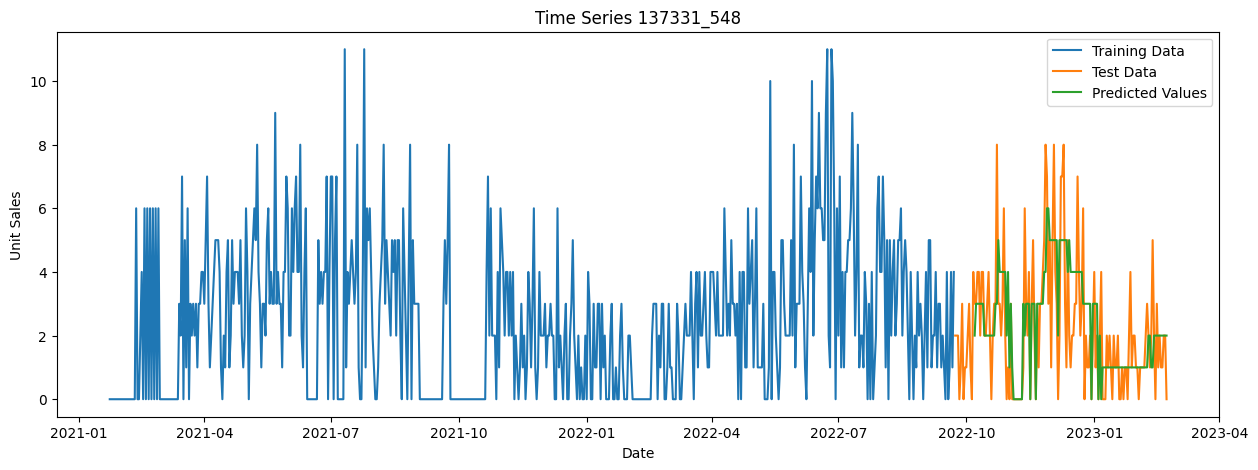

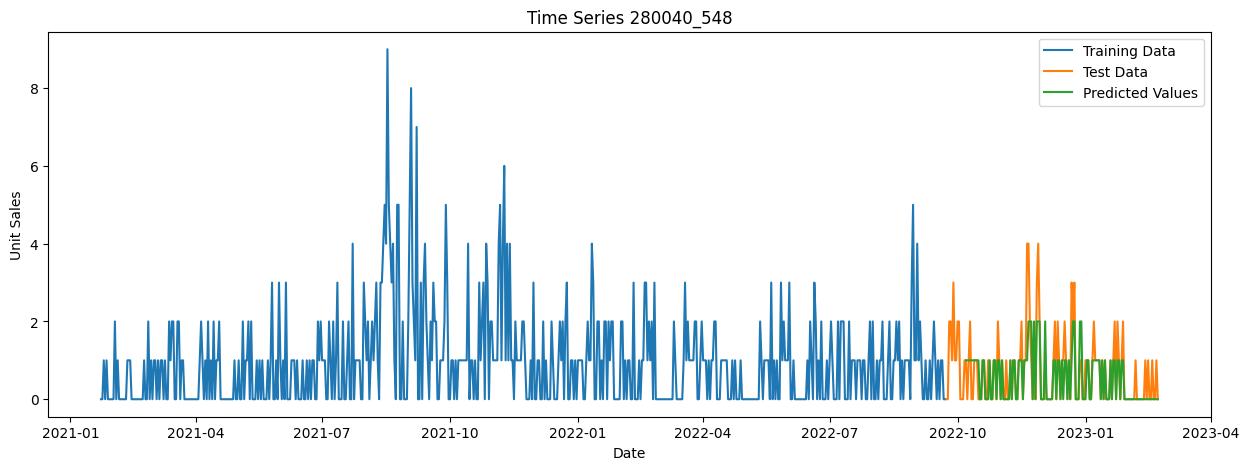

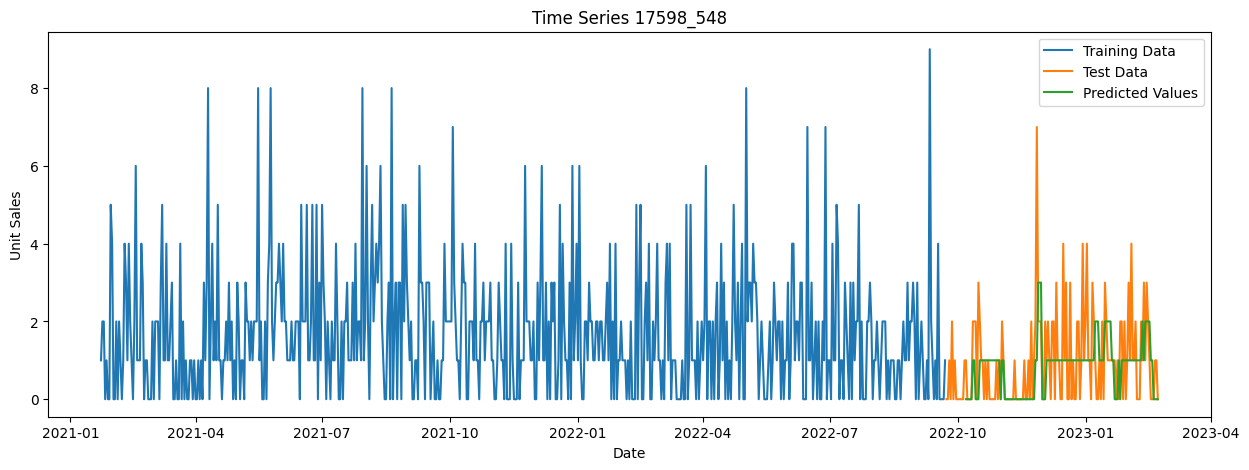

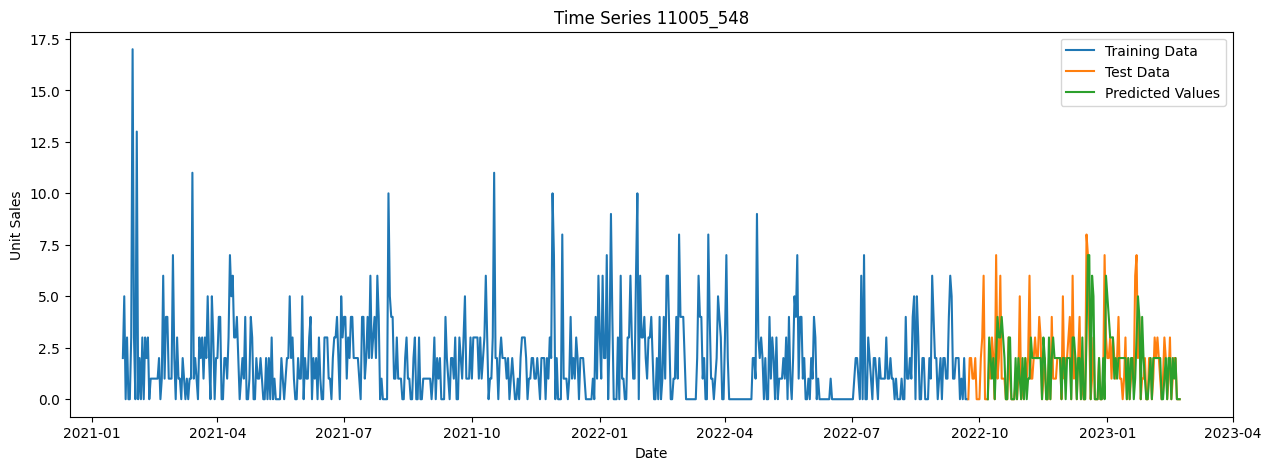

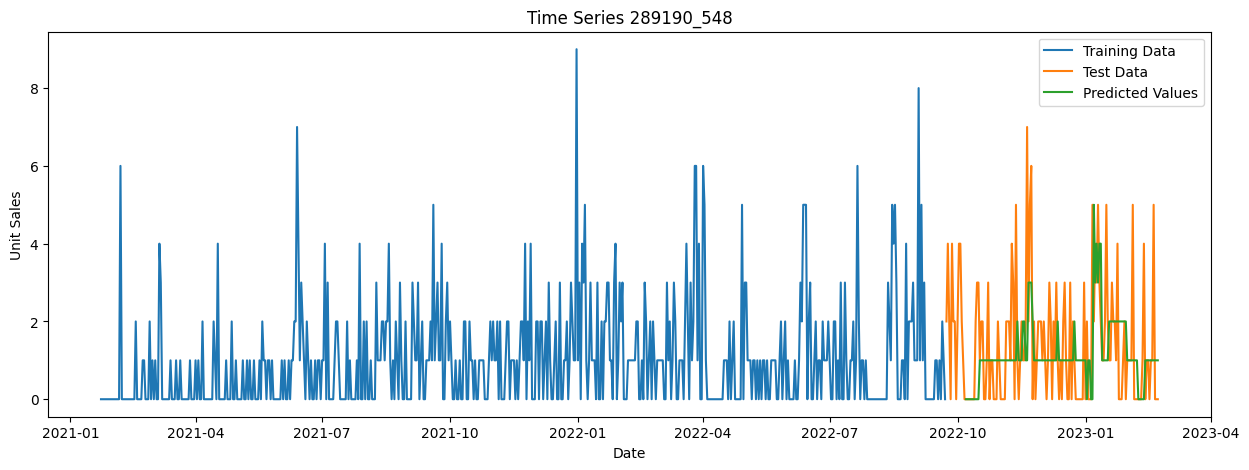

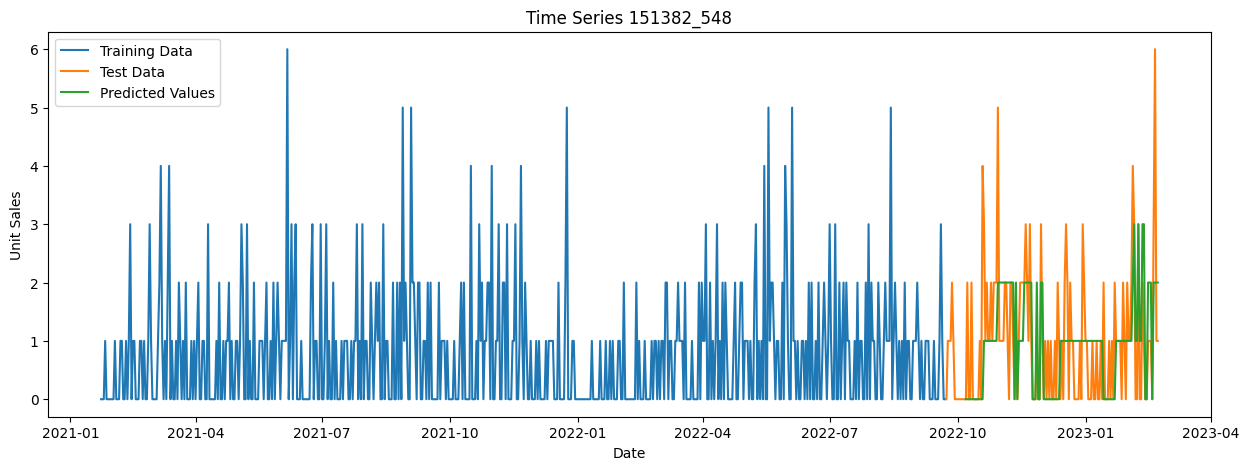

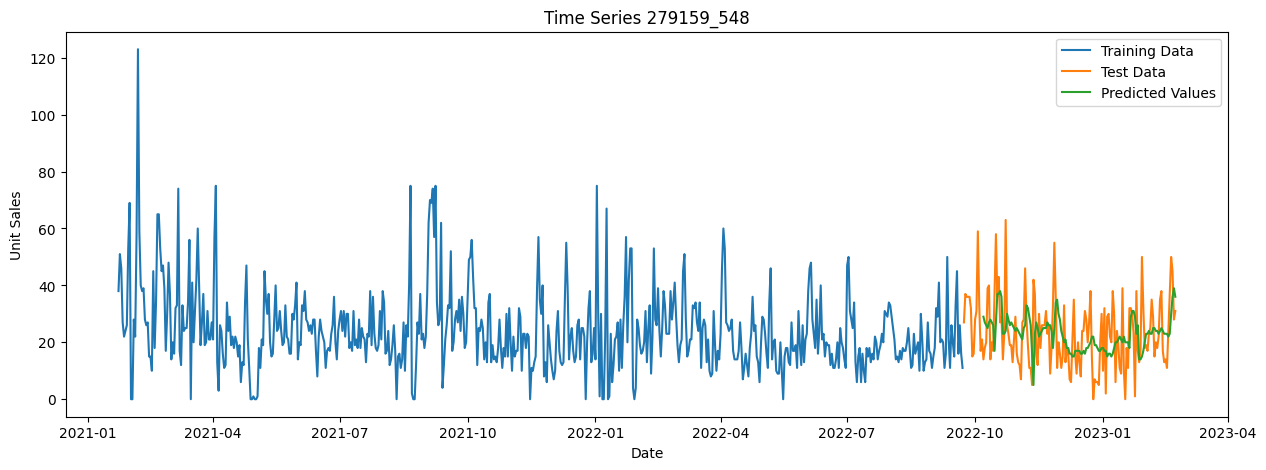

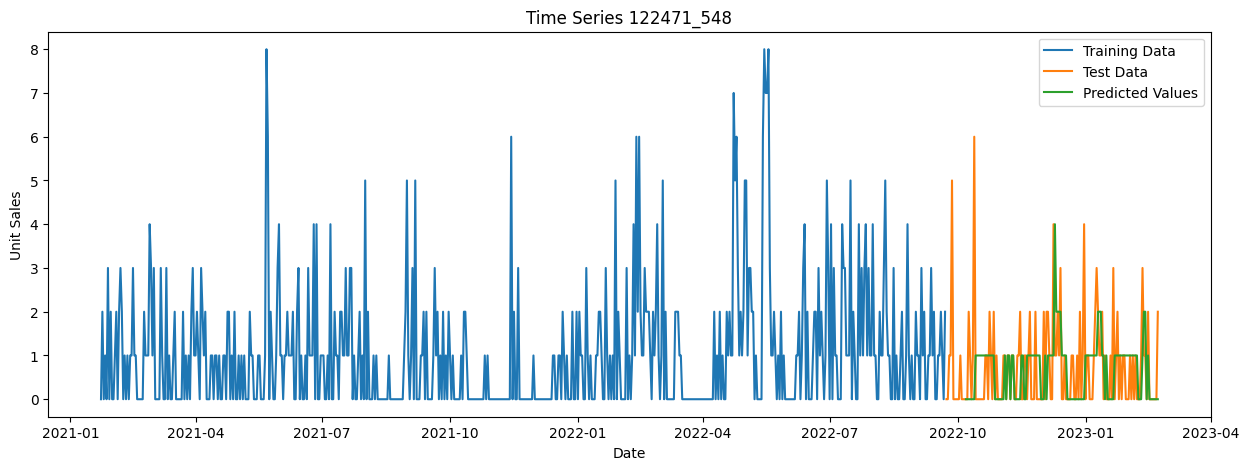

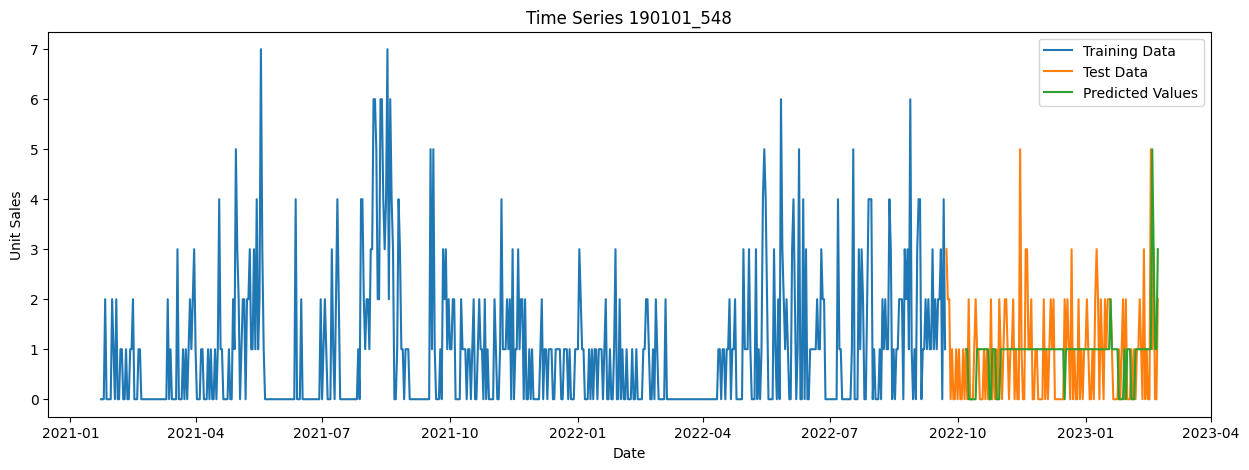

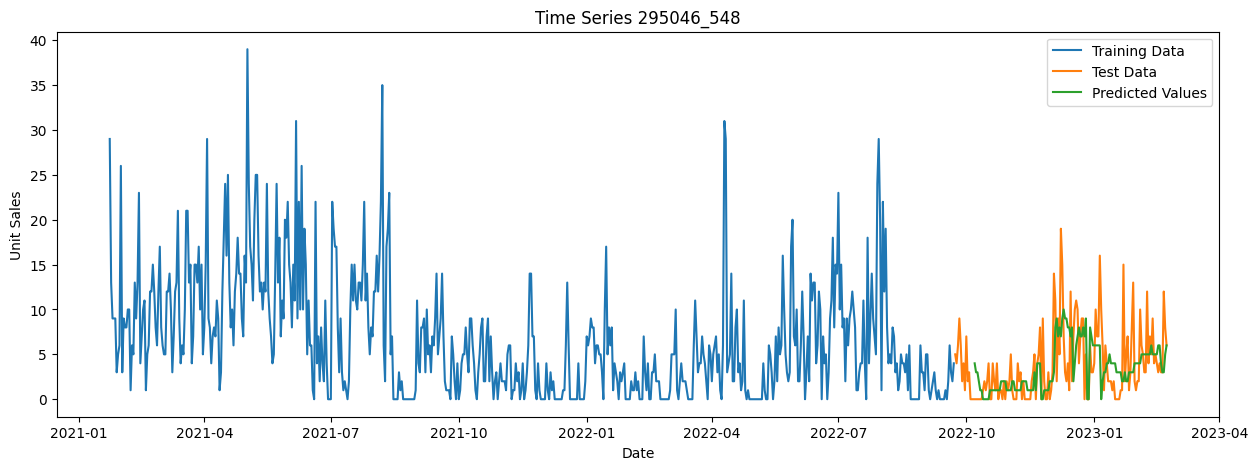

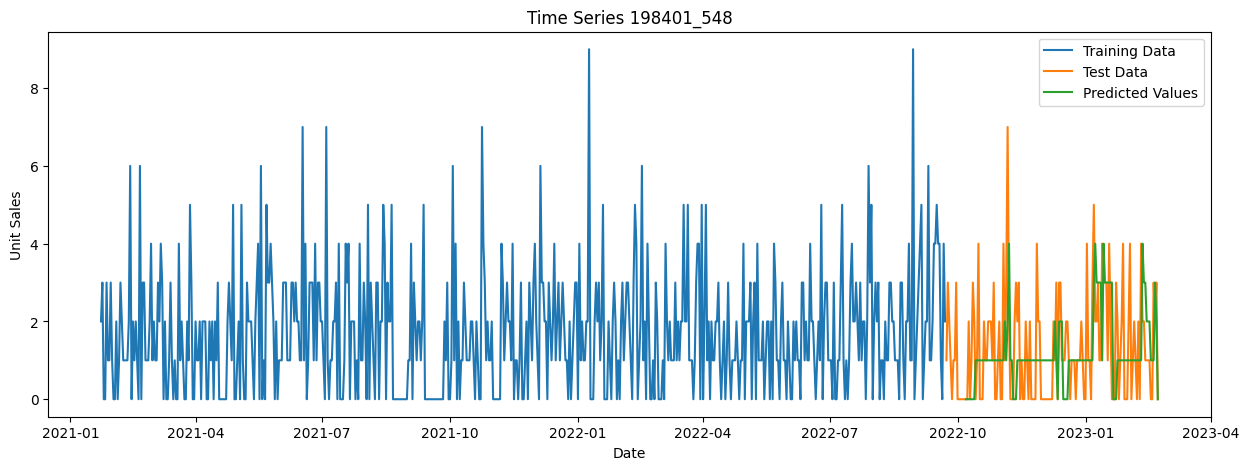

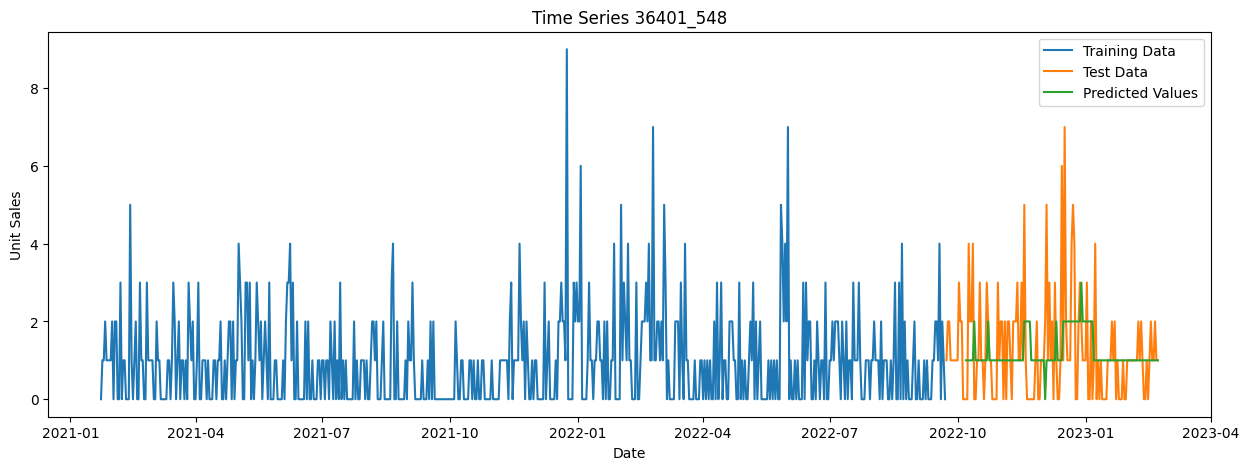

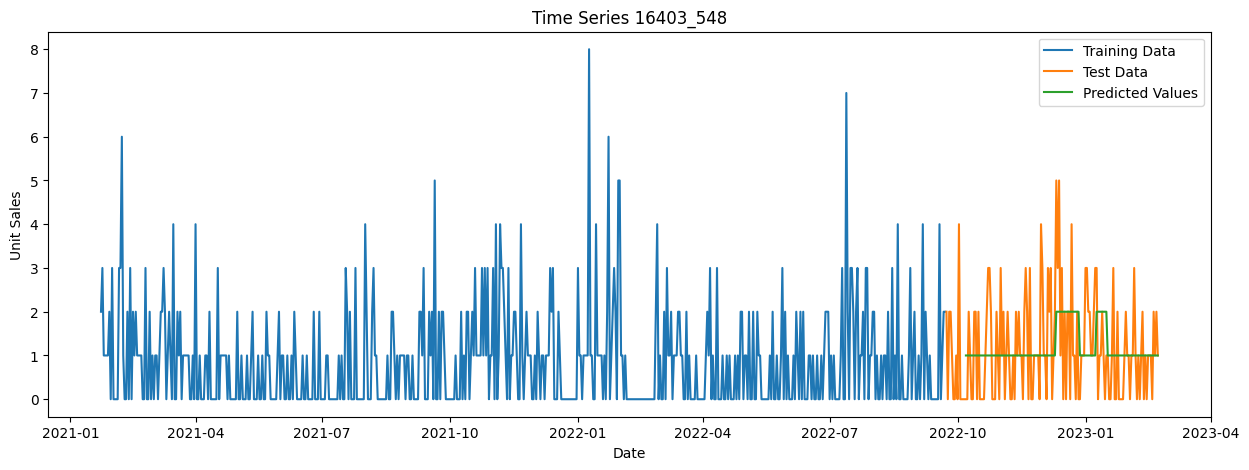

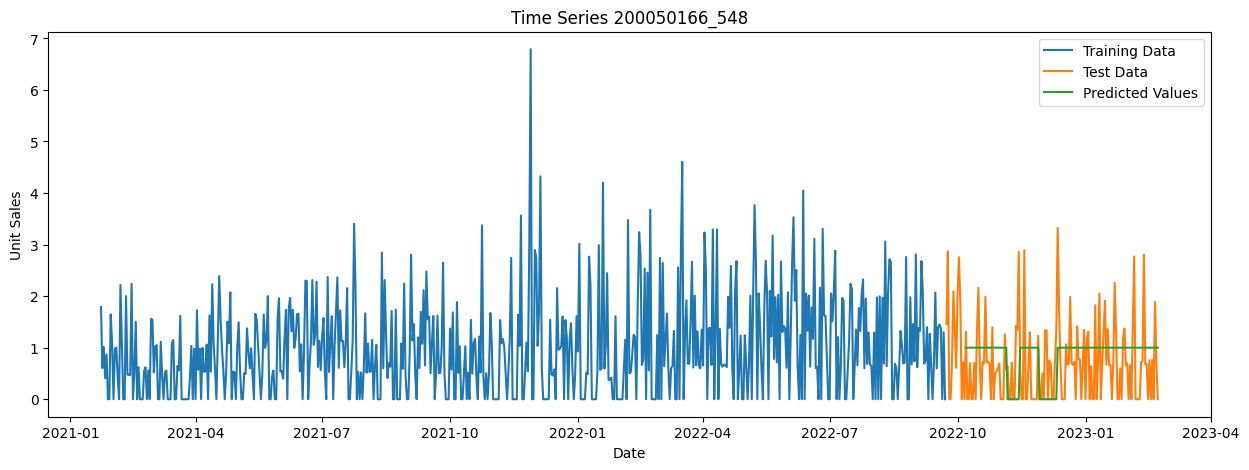

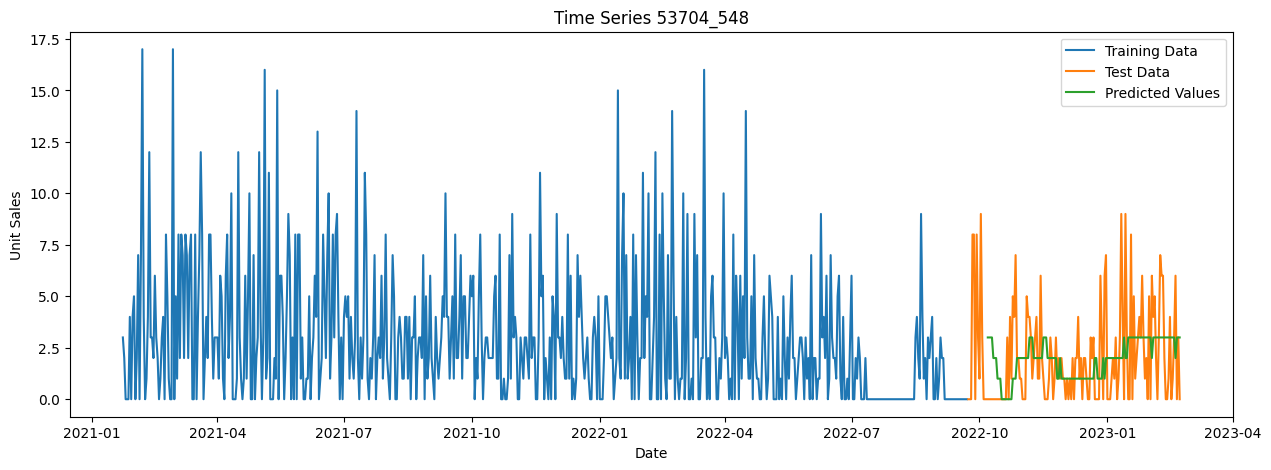

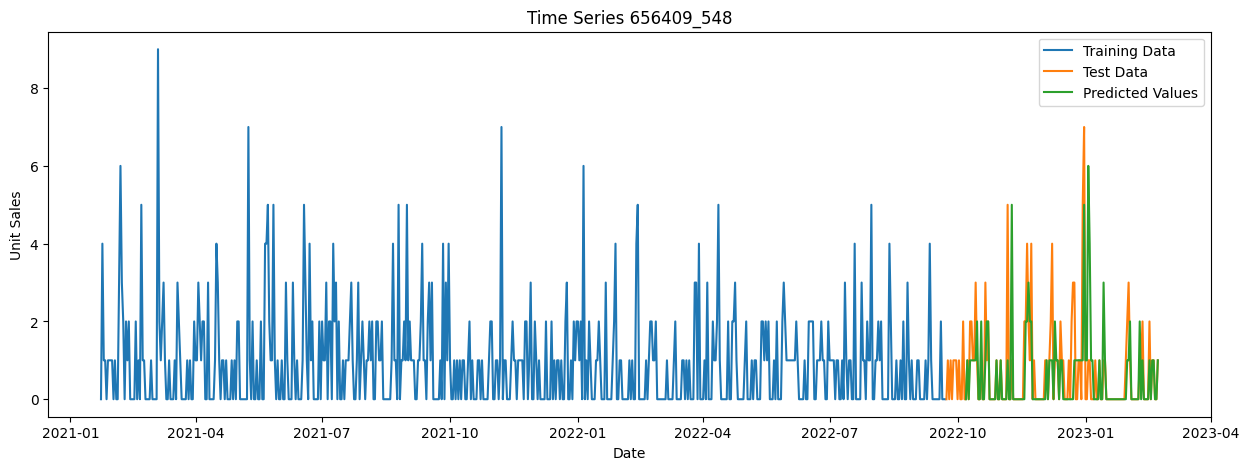

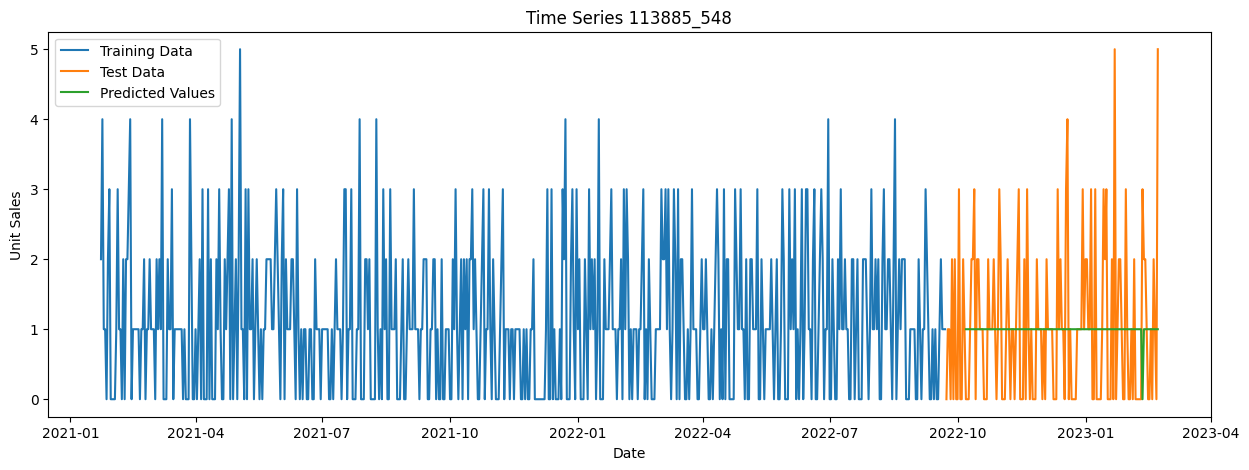

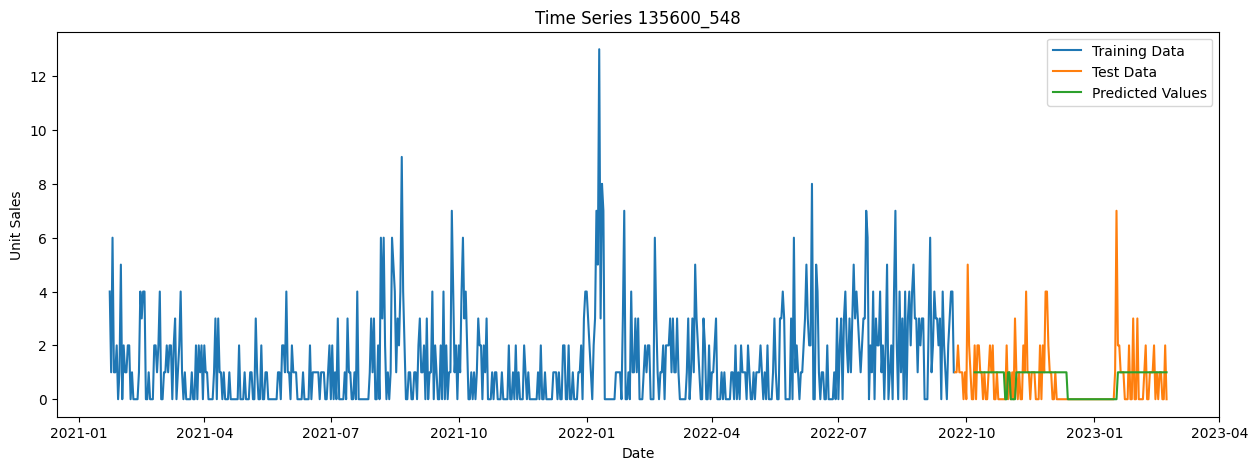

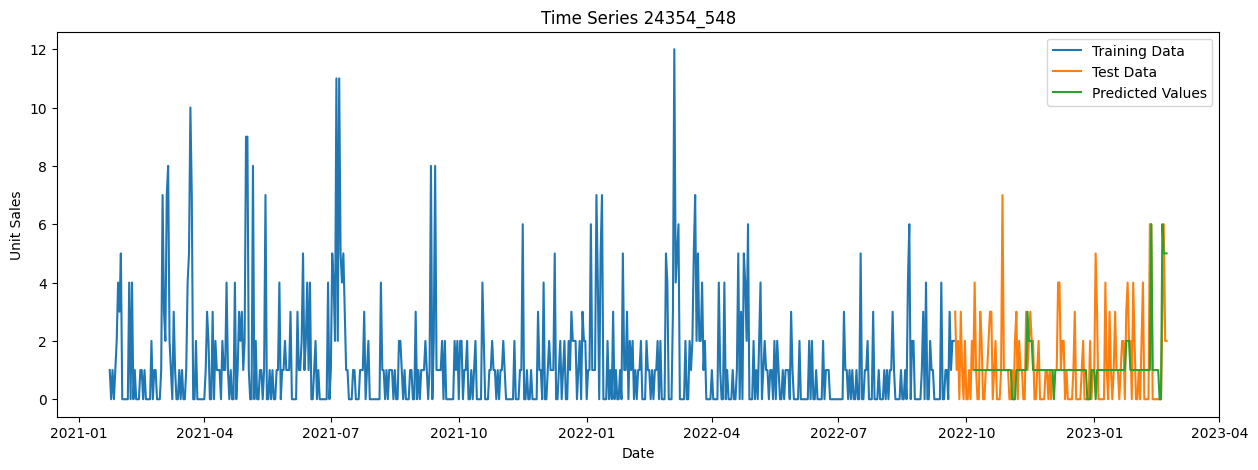

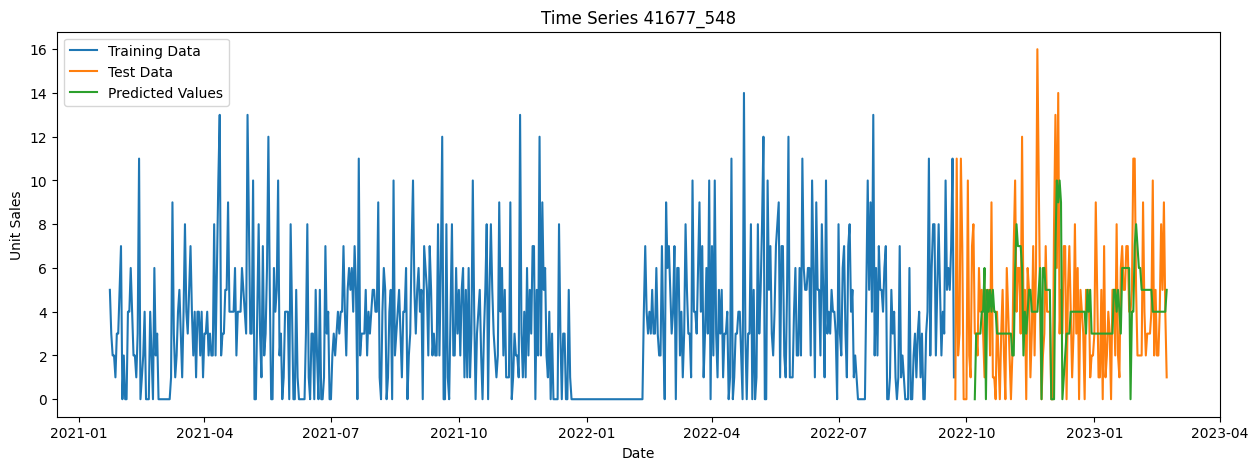

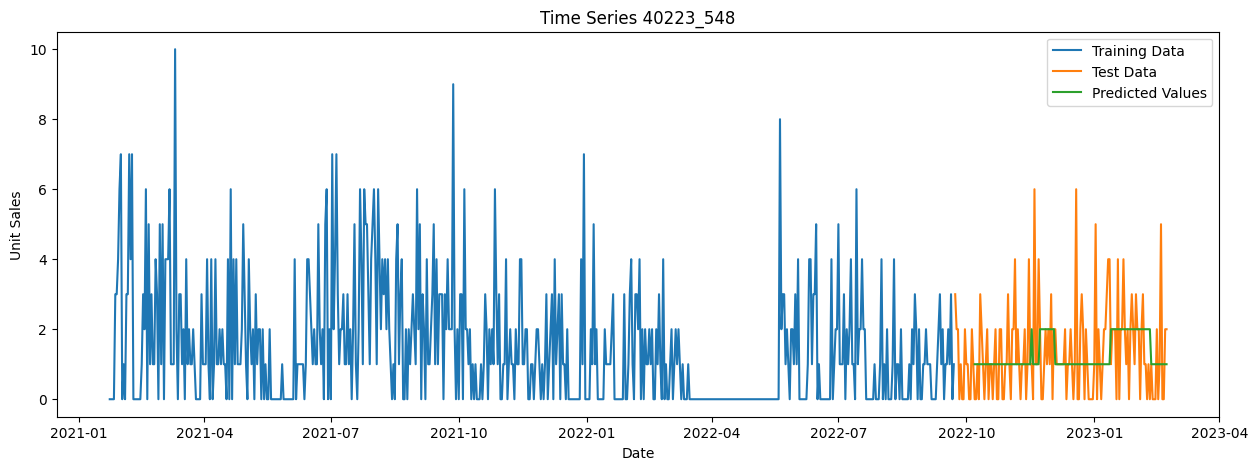

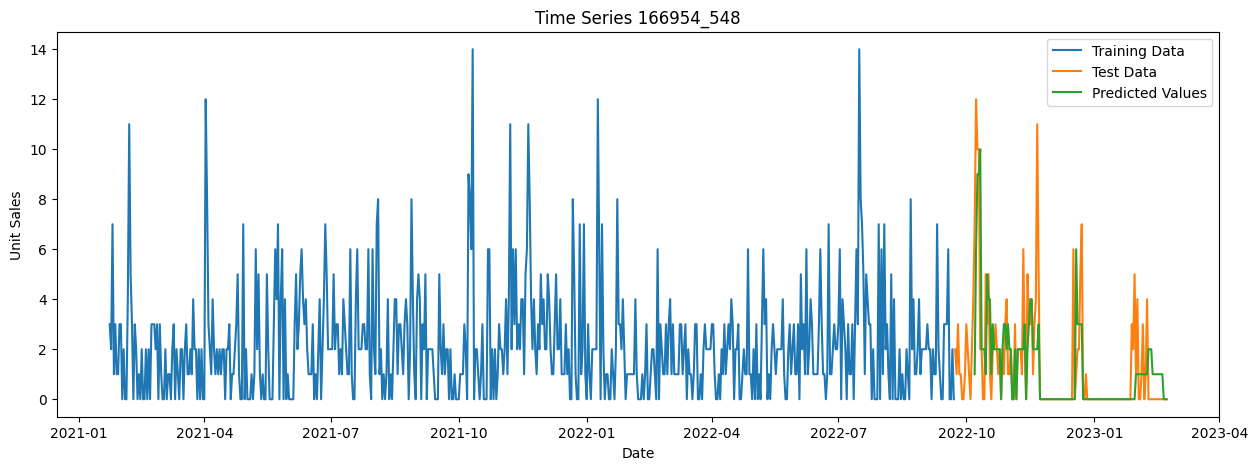

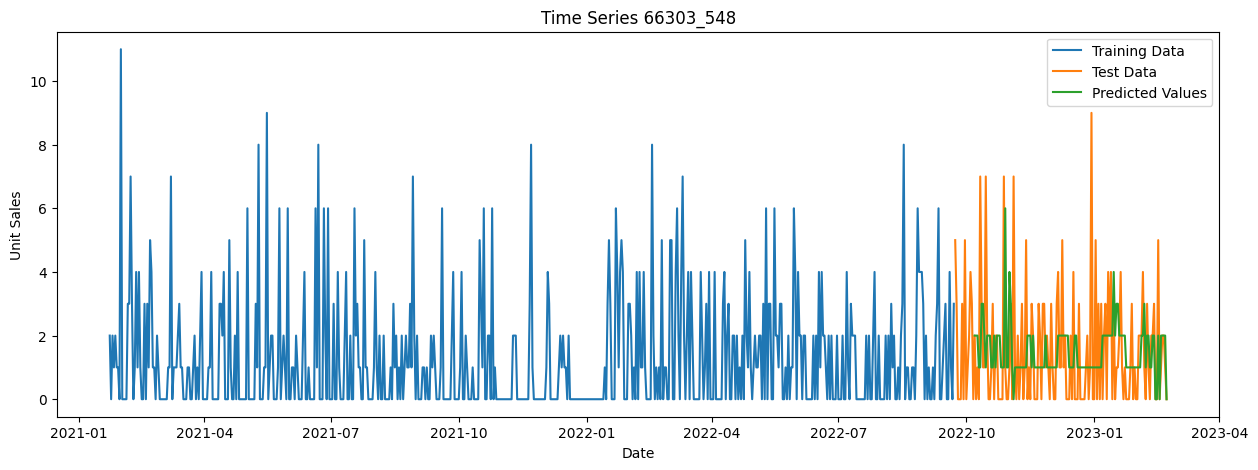

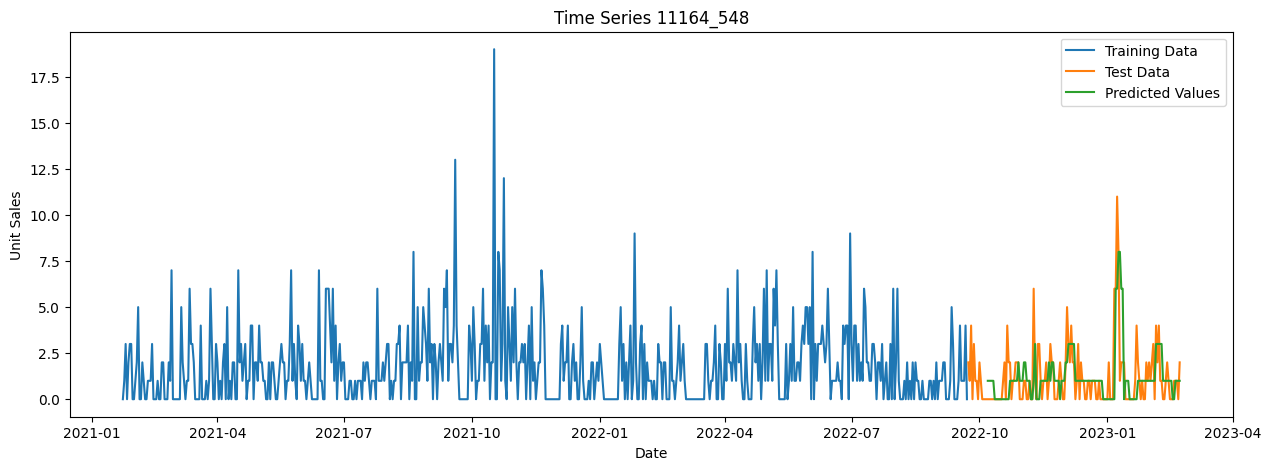

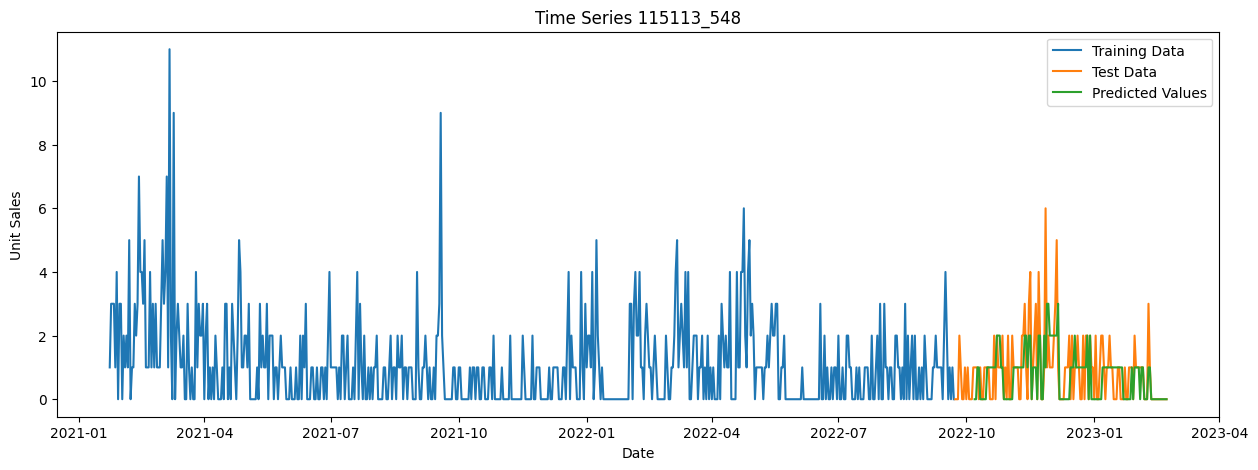

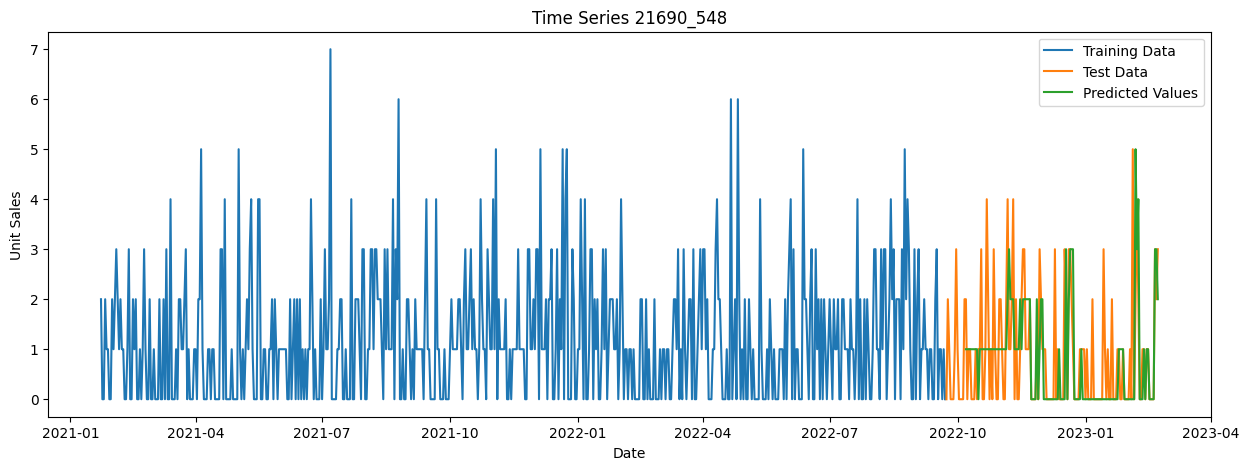

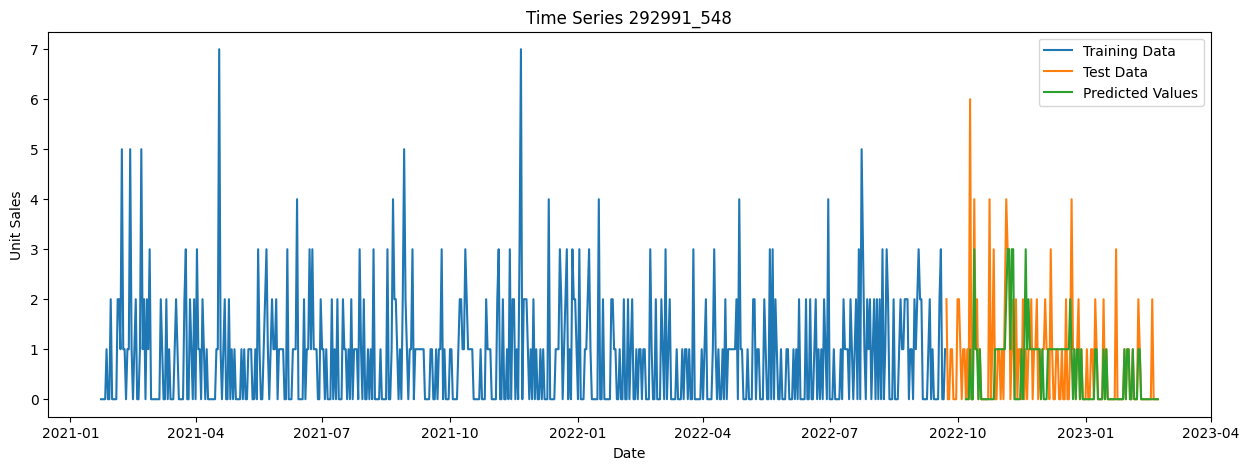

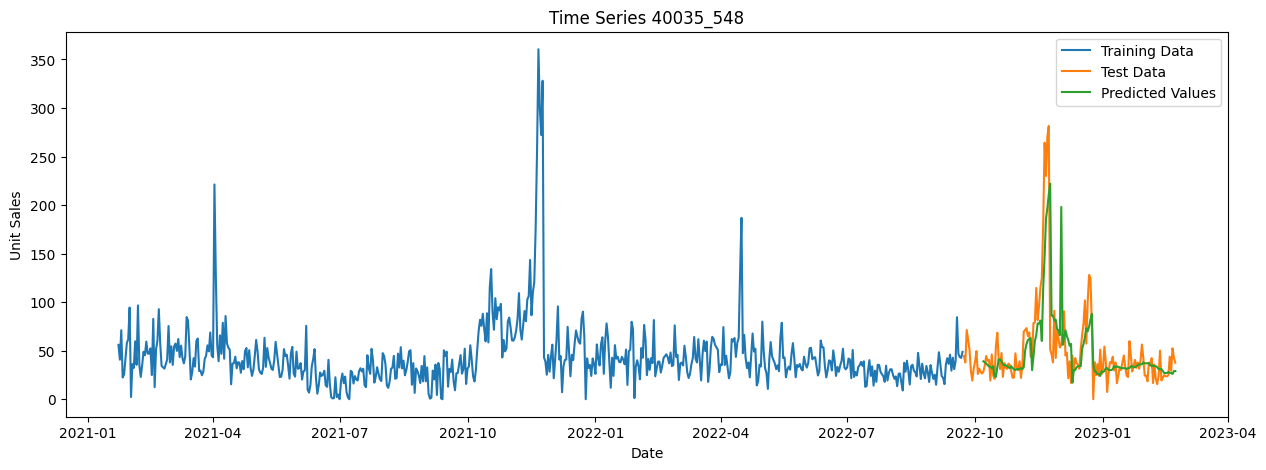

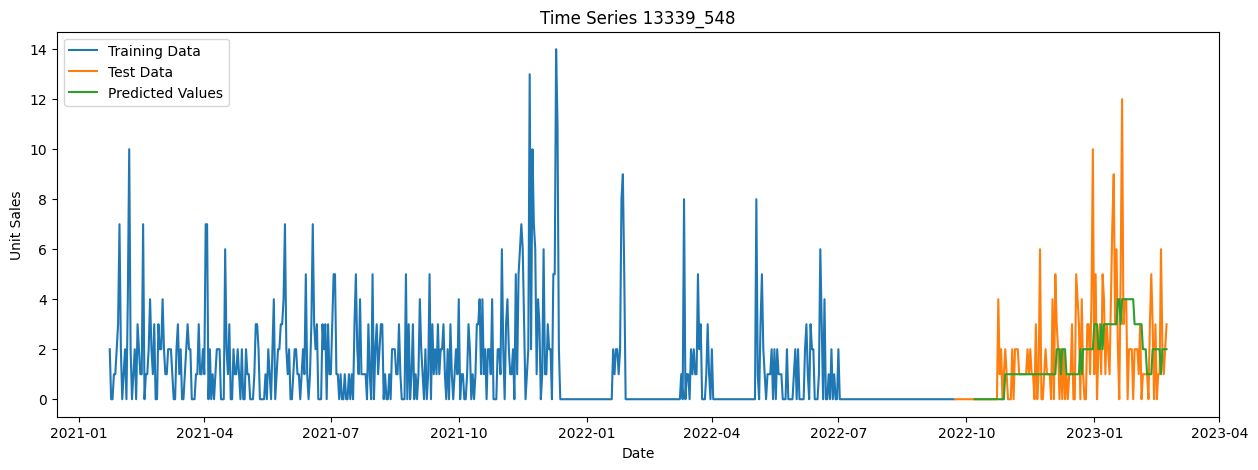

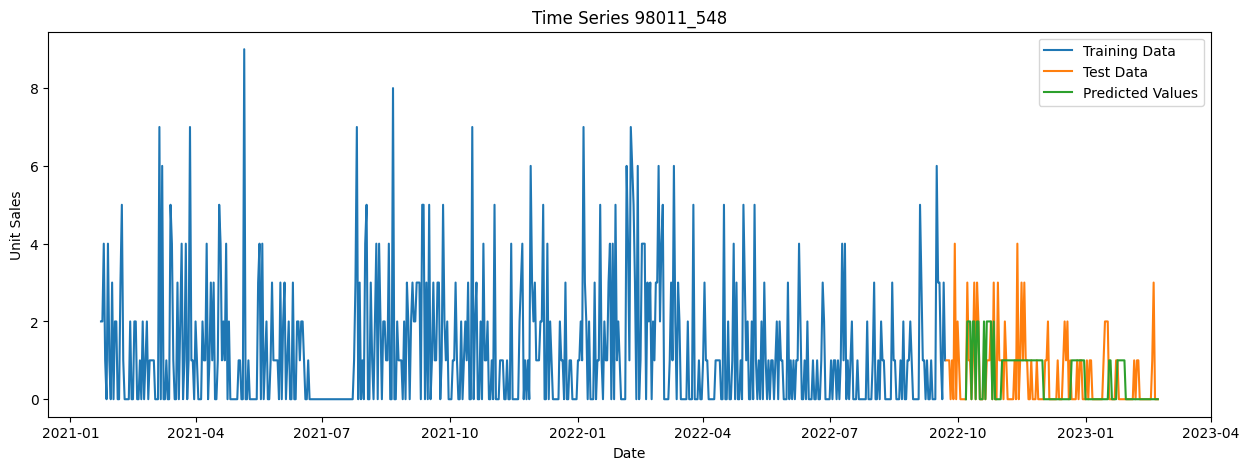

In [10]:
import matplotlib.pyplot as plt

# Loop through each unique_id in the test set
for unique_id in random_unique_ids:
    # Filter the data for the current unique_id
    train_filtered = train_test_data[unique_id]['train']
    test_filtered = train_test_data[unique_id]['test']
    results_filtered = predictions_df[predictions_df['unique_id'] == unique_id]

    # Extract the unit sales values for the current unique_id
    Y_train_filtered = train_filtered[TARGET].values
    Y_test_filtered = test_filtered[TARGET].values

    # Get the predicted values directly from the 'results_filtered' DataFrame
    Y_pred_filtered = results_filtered['predicted'].values

    # Plot the training data, test data, and predicted values for the current unique_id
    plt.figure(figsize=(15, 5))
    plt.plot(train_filtered.index[-len(Y_train_filtered):], Y_train_filtered, label='Training Data')
    plt.plot(test_filtered.index[:len(Y_test_filtered)], Y_test_filtered, label='Test Data')
    plt.plot(results_filtered['date'][:len(Y_pred_filtered)], Y_pred_filtered, label='Predicted Values')
    plt.title(f"Time Series {unique_id}")
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()

# Evaluation Metrics

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_scaled_error(actuals, predicted, seasonality=1):
    mae = np.mean(np.abs(actuals - predicted))
    naive_mae = np.mean(np.abs(actuals[seasonality:] - actuals[:-seasonality]))
    return mae / naive_mae

results = []

# Loop through each unique_id in the predictions_df
for unique_id in random_unique_ids:
    unique_id_predictions = predictions_df[predictions_df['unique_id'] == unique_id]
    actuals = unique_id_predictions['actuals'].values
    predicted = unique_id_predictions['predicted'].values

    # Calculate the error metrics
    mae = mean_absolute_error(actuals, predicted)
    rmse = np.sqrt(mean_squared_error(actuals, predicted))
    mase = mean_absolute_scaled_error(actuals, predicted)

    results.append({'unique_id': unique_id,
                    'MAE': mae,
                    'RMSE': rmse,
                    'MASE': mase})

# Save the results in a new DataFrame
results_df = pd.DataFrame(results)

results_df.to_csv('metrics_xgboost.csv', index=False)

results_df


unique_id        MAE       RMSE      MASE
0      137331_548   1.158273   1.624896  0.704149
1      280040_548   0.280576   0.605728  0.361864
2       17598_548   0.805755   1.187465  0.708244
3       11005_548   1.064748   1.734126  0.597298
4      289190_548   1.100719   1.538475  0.816663
5      151382_548   0.712230   1.042272  0.687327
6      279159_548  10.143885  12.541729  0.921564
7      122471_548   0.755396   1.141121  0.777945
8      190101_548   0.834532   1.125250  0.762685
9      295046_548   2.741007   3.773249  0.887932
10     198401_548   1.115108   1.431908  0.864522
11      36401_548   0.942446   1.343784  0.788228
12      16403_548   0.884892   1.147409  0.758479
13  200050166_548   0.674281   0.828095  0.891888
14      53704_548   1.762590   2.277510  0.887728
15     656409_548   0.539568   1.102646  0.636414
16     113885_548   0.848921   1.131625  0.796946
17     135600_548   0.647482   1.079568  0.842948
18      24354_548   1.028777   1.451866  0.825414
19      41677_548   2.546763   3.191716  0.802405
20      40223_548   0.928058   1.349127  0.681234
21     166954_548   0.920863   1.858289  0.779627
22      66303_548   1.402878   1.947143  0.696393
23      11164_548   0.956835   1.547800  0.880288
24     115113_548   0.640288   0.992780  0.695746
25      21690_548   0.676259   1.086212  0.671394
26     292991_548   0.546763   1.010734  0.523981
27      40035_548  17.926619  30.127150  1.008472
28      13339_548   1.309353   1.992793  0.749754
29      98011_548   0.611511   0.925265  0.827338

In [12]:
import plotly.graph_objs as go

# Create a box plot for MAE
trace1 = go.Box(
    y=results_df['MAE'],
    name="MAE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for RMSE
trace2 = go.Box(
    y=results_df['RMSE'],
    name="RMSE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for MASE
trace3 = go.Box(
    y=results_df['MASE'],
    name="MASE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a layout for the box plots
layout = go.Layout(
    title="Evaluation Metrics Box Plots",
    yaxis=dict(title="Value"),
    boxmode='group'
)

# Combine the traces and layout into a single figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Plot the figure
fig.show()

# Interpretability

# Built-in Interpretability


In [15]:
xgb.plot_importance(reg)
plt.show()

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

# SHAP


In [ ]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

# Create a TreeExplainer object
explainer = shap.TreeExplainer(reg)

# Calculate SHAP values
shap_values = explainer.shap_values(X_all)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_all)

# Plot SHAP dependence plots for each feature
#for feature in FEATURES:
    #shap.dependence_plot(feature, shap_values, X_all)


In [ ]:
# Calculate SHAP values for the validation data
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_all)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_all, plot_type="bar")